In [19]:
"""
Python script for rock physics and 4D modelling for the Master`s thesis by Jørgen Inderhaug Austad
"""

'\nPython script for rock physics and 4D modelling for the Master`s thesis by Jørgen Inderhaug Austad\n'

In [1]:
pip install "numpy<2.0" #Installing numpy version required for rockphypy

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install rockphypy #Installing module by Yu et al. (2023)

  Using cached rockphypy-0.0.2-py3-none-any.whl.metadata (4.4 kB)
  Using cached kde_diffusion-1.0.5-py3-none-any.whl.metadata (1.6 kB)
Using cached rockphypy-0.0.2-py3-none-any.whl (59 kB)
Using cached kde_diffusion-1.0.5-py3-none-any.whl (7.6 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import rockphypy
from rockphypy import GM
from rockphypy import EM
from rockphypy import Fluid
from rockphypy import BW
from rockphypy import utils
from rockphypy import QI
import matplotlib.colors

In [4]:
"""
Disclaimers
(1) Salinity and G is not used in the script, but was  used as input in functions BW.rho_K_co2(P0, T0, G) and BW.rho_K_brine(T0, T0, salinity) to obtain rho and K of co2 and brine
(2) Quartz cement parameters are used at Sleipner to plot the cement  models for visualization purposes, but are not used for further calculations 
(3) G is generally shear moduli in this code, except for self.G, which is the gas gravity factor
(4) Fluid.vels(...) calculates K_sat, rho_bulk and mu_sat within and return seismic velocities 
(5) Even though fluid shear moduli is assumed to be 0, it is set to 1/1e40 to account for issues dividing by zero.
(6) The classes Aurora, Sleipner and Snøhvit are generally copy paste, but adjusted to accound for differences such as rock physics parameters and models, well-sorted end members, brie exponents, offsets and shale properties among some.
"""

'\nDisclaimers\n(1) Salinity and G is not used in the script, but was  used as input in functions BW.rho_K_co2(P0, T0, G) and BW.rho_K_brine(T0, T0, salinity) to obtain rho and K of co2 and brine\n(2) Quartz cement parameters are used at Sleipner to plot the cement  models for visualization purposes, but are not used for further calculations \n(3) G is generally shear moduli in this code, except for self.G, which is the gas gravity factor\n(4) Fluid.vels(...) calculates K_sat, rho_bulk and mu_sat within and return seismic velocities \n(5) Even though fluid shear moduli is assumed to be 0, it is set to 1/1e40 to account for issues dividing by zero.\n(6) The classes Aurora, Sleipner and Snøhvit are generally copy paste, but adjusted to accound for differences such as rock physics parameters and models, well-sorted end members, brie exponents, offsets and shale properties among some.\n'

In [5]:
"""
rockphypy function overview and explanation:

VRH() returns Voigt, Reuss and Voigt-Reuss-Hill bound from Equations 3.3 and 3.4
HS() returns either upper of lower Hashin-Shtrikman bound, depending on argument
GM.softsand() returns friable-sand model K and G of dry rock frame from Equation 3.12
GM.contactcement() returns contact-cement model K and G of dry rock frame from Equation 3.13
GM.constantcement() returns constant-cement model K and G of dry rock frame from Equation 3.14
Fluid.vels() returns seismic velocities (Equation 3.1 and 3.2) by calculating K_sat and G_sat given by Gassmann model (Equation 3.7) and rho_bulk (Equation 3.8) given neccessary arguments
Fluid.Brie() returns the bulk moduli of a fluid mixture according to Equation 3.9
"""

'\nrockphypy function overview and explanation:\n\nVRH() returns Voigt, Reuss and Voigt-Reuss-Hill bound from Equations 3.3 and 3.4\nHS() returns either upper of lower Hashin-Shtrikman bound, depending on argument\nGM.softsand() returns friable-sand model K and G of dry rock frame from Equation 3.12\nGM.contactcement() returns contact-cement model K and G of dry rock frame from Equation 3.13\nGM.constantcement() returns constant-cement model K and G of dry rock frame from Equation 3.14\nFluid.vels() returns seismic velocities (Equation 3.1 and 3.2) by calculating K_sat and G_sat given by Gassmann model (Equation 3.7) and rho_bulk (Equation 3.8) given neccessary arguments\nFluid.Brie() returns the bulk moduli of a fluid mixture according to Equation 3.9\n'

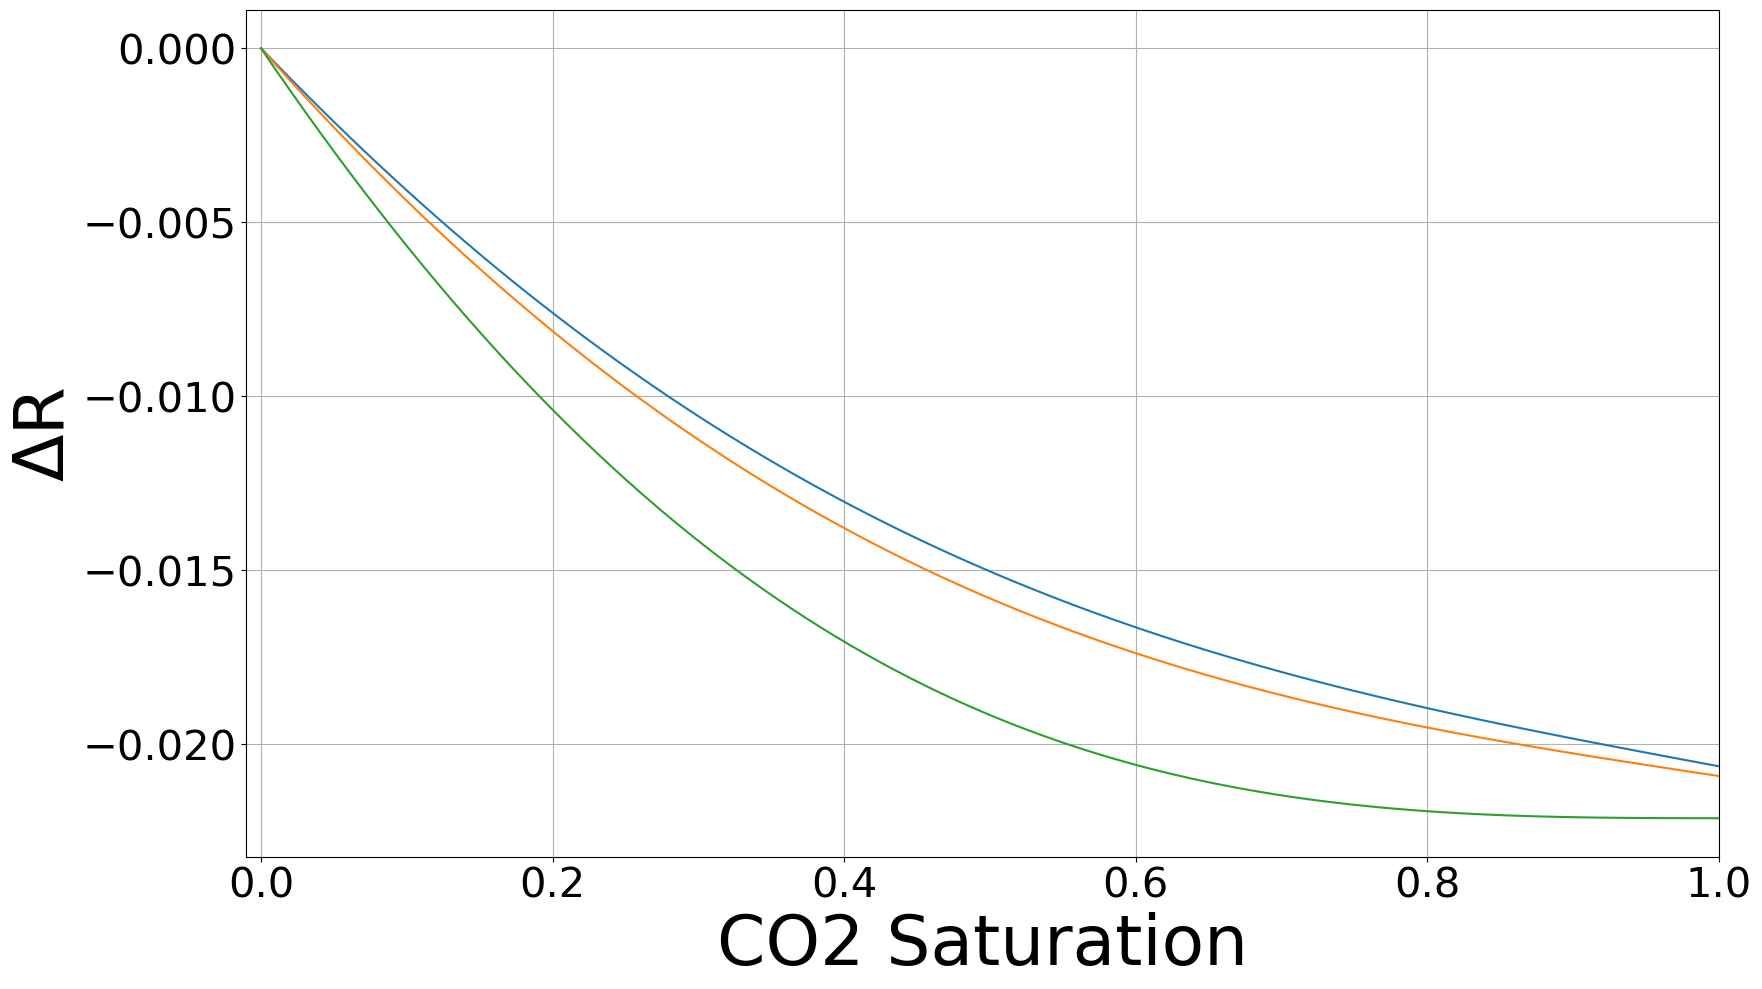

In [9]:
class AuroraModel(EM, Fluid, BW, utils, GM):
    def __init__(self):
        super().__init__()  #Initialize rockphypy
        self.cores = [ 
            #Data from core samples at proper effective stress.
            {"velocity": 3700, "porosity": 0.228, "water_saturation": 1, "fm": "johansen"}, #T2467
            {"velocity": 3650, "porosity": 0.225, "water_saturation": 1, "fm": "johansen"}, #T2469
            {"velocity": 4000, "porosity": 0.228, "water_saturation": 1, "fm": "cook"}, #T2476
            {"velocity": 3580, "porosity": 0.295, "water_saturation": 1, "fm": "johansen"}, #T2479
            {"velocity": 3750, "porosity": 0.201, "water_saturation": 1, "fm": "johansen"}, #T2480
            {"velocity": 3950, "porosity": 0.245, "water_saturation": 1, "fm": "cook"} #T2482
        ] 
        #---------Table  5.1.1----------#
        self.G = 0.951
        self.P0, self.T0 = 27, 100
        self.sigma = 26
        self.K0, self.G0 = 37.09, 38.78
        self.porosity = 0.24
        self.phic = 0.4   
        self.rho_grain = 2.64
        self.rho_c, self.K_c, self.G_c = 2.65, 37, 44
        self.rho_brine, self.K_brine = 1.03, 3.1
        self.rho_co2, self.K_co2 = 0.668, 2.022
        self.G_brine, self.G_co2 = 1/1e40, 1/1e40
        self.salinity = 80000
        #--------------------------------#

        self.Sw_values = np.linspace(1, 0, 100)
        self.phi_values = np.linspace(1e-9, 1, 100)
        self.f = 0.1 #reduced shear factor
        self.scheme = 1 #cementation scheme
        self.phib_p = [0.35,0.3986, 0.39968] #well-sorted end members
        self.phic_ = np.linspace(1e-9, self.phic, 100)
        self.C = 20-34*self.porosity + 14*self.porosity**2 #Equation 3.11

    def calculate_vp_vs(self, K_sat, G_sat, rho):
        Vp = np.sqrt((K_sat + (4 / 3) * G_sat) / rho) #Equation 3.1
        Vs = np.sqrt(G_sat / rho) #Equation 3.2
        return Vp, Vs 

    def plot_bounds_and_critical_porosity(self): #Calculating and plotting rock physics bounds 
        volumes = np.vstack((1 -  self.phi_values, self.phi_values)).T
        K = np.array([self.K0, self.K_brine])
        G = np.array([self.G0, self.G_brine])
        K_v, K_r, K_h = self.VRH(volumes, K)
        G_v, G_r, G_h = self.VRH(volumes, G)
        K_UHS, G_UHS = self.HS(1 -  self.phi_values, self.K0, self.K_brine, self.G0, self.G_brine, bound='upper')
        K_LHS, G_LHS = self.HS(1 -  self.phi_values, self.K0, self.K_brine, self.G0, self.G_brine, bound='lower')
        
        rho_bulk = (self.rho_grain * (1 - self.phi_values) + self.rho_brine * self.phi_values)*1e3 #Equation 3.8
        
        plt.figure(figsize=(15, 11))
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlabel('Porosity', fontsize=50)
        plt.xlim(-0.01,1)
        plt.ylabel('P-wave Velocity [m/s]', fontsize=50)
        plt.plot(self.phi_values, self.calculate_vp_vs(K_v*1e9, G_v*1e9,rho_bulk)[0], label='Voigt',linestyle='-',color='blue')
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_r*1e9, G_r*1e9,rho_bulk)[0], label='Reuss',linestyle='--',color='red',linewidth=3)
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_h*1e9, G_h*1e9, rho_bulk)[0], label='Voigt-Reuss-Hill',linestyle='-.',color='green')
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_UHS*1e9, G_UHS*1e9, rho_bulk)[0], label='Hashin-Shtrikman Upper',linestyle=':',color='purple')
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_LHS*1e9, G_LHS*1e9, rho_bulk)[0], label='Hashin-Shtrikman Lower',linestyle='-',color='black')
        plt.plot(self.phi_values,  (self.calculate_vp_vs(K_UHS*1e9, G_UHS*1e9, rho_bulk)[0]+ self.calculate_vp_vs(K_LHS*1e9, G_LHS*1e9,rho_bulk)[0])/2, label='Hashin-Shtrikman Average',linestyle='-',color='orange')
        
        #plotting data points
        x,y = [], []
        for core in self.cores:
            x.append(core['porosity'])
            y.append(core['velocity'])
        plt.scatter(x, y, marker="o", s=100, color='black', label=f"Core data from Aurora")
        
        plt.grid(True)
        plt.savefig("Bounds_Aurora.png")
        plt.show()

    def plot_sand_models(self): #Plotting the high-porosity sandstone models
        plt.figure(figsize=(15,11))
        K_fri, G_fri = GM.softsand(self.K0, self.G0, self.phic_, self.phic, self.C, self.sigma, self.f)
        K_contcem, G_contcem = GM.contactcement(self.K0, self.G0, self.K_c, self.G_c,self.phic_, self.phic, self.C, self.scheme)
        K_contcem[self.phic_ < self.phib_p[0]], G_contcem[self.phi_values < self.phib_p[0]] = np.nan, np.nan
        for element in self.phib_p:
            K_constcem, G_constcem = GM.constantcement(element, self.K0, self.G0, self.K_c, self.G_c, self.phic_, self.phic, self.C, self.scheme)
            K_constcem[self.phic_ > element] = np.nan
            Vp_constcem, Vs_constcem, _ = Fluid.vels(K_constcem, G_constcem, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.phic_)
            
            plt.plot(self.phic_, Vp_constcem, label=f"Constant Cement Model, High-porosity end-member: {element}, Avseth (2000)", color="green", linestyle="-")
        Vp_fri, Vs_fri, _ = Fluid.vels(K_fri, G_fri, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.phic_)
        Vp_contcem, Vs_contcem, _ = Fluid.vels(K_contcem, G_contcem, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.phic_)
        plt.plot(self.phic_, Vp_fri, label=f"Softsand (Friable Sand) Model, Avseth et al. (2010)", color="blue")
        plt.plot(self.phic_, Vp_contcem, label=f"Contact Cement Model, Dvorkin & Nur (1996)", color="red")

        #plotting data points
        x_cook, y_cook, x_joh, y_joh = [], [], [], []
        for core in self.cores:
            if core["fm"] == "cook":
                x_cook.append(core['porosity'])
                y_cook.append(core['velocity'])
            else:
                x_joh.append(core['porosity'])
                y_joh.append(core['velocity'])
        plt.scatter(x_cook, y_cook, marker="o", s=100, color='black', label=f"Core data from Cook formation (NGI)")
        plt.scatter(x_joh, y_joh, marker="x", s=100, color='black', label=f"Core data from Johansen formation (NGI)")
        
        plt.xlabel("Porosity", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlim(-0.01, 0.50)
        plt.ylabel("P-wave Velocity [m/s]", fontsize=50)
        plt.grid(True)
        plt.savefig(f"Cementation_Models_Aurora.png")
        plt.show()

    def GassmannSubst(self, brie_exponents): #Gassmann fluid substitution for different Brie exponents 
        #Choose which well-sorted end member, which tells which formation the substitution is done for
        end_memb = 0.3985 #cook
        #end_memb = 0.39965 #johansen
        
        plt.figure(figsize=(15, 10))

        #Appropriate rock physics model. Here it is determined to be constant-cement model.
        K_dry, G_dry = GM.constantcement(end_memb, self.K0, self.G0, self.K_c, self.G_c, self.porosity, self.phic, self.C, self.scheme)
        for brie in brie_exponents:
            K_fl_mix = Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, brie)
            
            rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values) #Equation 3.8 where phi=1

            #Calculate P-wave velocities for Gassmann substitution
            Vp = []
            for i in range(len(self.Sw_values)):
                Vp.append(Fluid.vels(K_dry, G_dry, self.K0, self.rho_grain, K_fl_mix[i], rho_fl_mix[i], self.porosity)[0])
            plt.plot(1 - self.Sw_values, Vp, label=f"Brie: {brie}")
        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel('P-wave Velocity [m/s]', fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig("GassmannSubst_AuroraC.png") #...C for Cook, ....J for Johansen
        plt.show()
    
    def plot_reflectivity(self, brie, theta): #Calculate reflectivity change
        end_memb = 0.3985 #cook
        plt.figure(figsize=(19,11))
        K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, brie)
        
        rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values) #Equation 3.8 for phi=1
        
        rho_bulk = self.rho_grain * (1 - self.porosity) + rho_fl_mix * self.porosity #Equation 3.8

        #Shale properties from Table 5.3.1
        Vp_sh, Vs_sh, rho_sh = 3250, 1350, (24.78*101.9716)/1e3 

        #The determined appropriate rock physics model
        K_best_fit, G_best_fit = GM.constantcement(end_memb, self.K0, self.G0, self.K_c, self.G_c, self.porosity, self.phic, self.C, self.scheme)

        #Calculate the Gassmann substituted velocities for appropriate rock physics model
        Vp_best_fit = []
        for i in range(len(self.Sw_values)):
            Vp_best_fit.append(Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix[i], rho_fl_mix[i], self.porosity)[0])
        a1, rho1 = Vp_sh, rho_sh

        #Calculate reflectivity from Equation 4.3 and different theta
        for angle_deg in theta:
            R_array = []
            angle_rad = np.radians(angle_deg)
            for i in range(len(self.Sw_values)):
                a2, rho2 = Vp_best_fit[i], rho_bulk[i]
                a = (a1 + a2) / 2
                rho = (rho1 + rho2) / 2
                da = a2 - Vp_best_fit[0]
                drho = rho2 - rho_bulk[0]
                R = 0.5 * ((drho / rho) + (da / a)) + 0.5 * (da / a) * (np.tan(angle_rad) ** 2)
                R_array.append(R)
                
            plt.plot(1 - self.Sw_values, R_array, label=f"Reflectivity (Constant cement)")
        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel("ΔR", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlim(-0.01, 1)
        plt.grid(True)
        plt.savefig(f"R_Aurora.png")
        plt.show()

    def plot_dt_reflected(self, Z, theta): #Calculate time-shift for reflected wave for different incidence angles
        end_memb = 0.39965 #Johansen well-sorted end member
        plt.figure(figsize=(15, 11))
        
        dZ = 0 #assumed no thickness change

        
        K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, 3) #Equation 3.9
        rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values) #Equation 3.8 where phi=1

        #Appropriate rock physics model
        K_best_fit, G_best_fit = GM.constantcement(end_memb, self.K0, self.G0, self.K_c, self.G_c, self.porosity, self.phic, self.C, self.scheme)
        
        #Calculate the Gassmann substituted velocities for appropriate rock physics model
        Vp = Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix, rho_fl_mix, self.porosity)[0]

        #Calculate time-shift for different incidence angles according to Equation 4.5
        for angle in theta:
            angle = angle*(np.pi/180) #to radians
            dT = []
            s = Z/np.cos(angle)
            for i in range(len(self.Sw_values)):
                T1 = 2 * s / Vp[0]
                dt = (dZ - (1 + np.tan(angle) ** 2) * ((Vp[i] - Vp[0]) / Vp[0])) * T1
                dT.append(dt * 1000)  #Convert to milliseconds
                
            plt.plot(1 - self.Sw_values, dT, label=f"Angle = {angle*(180/np.pi)} degrees")
        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel("ΔT [ms]", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig(f"dT_Aurora.png")
        plt.show()

    def plot_dt_diving(self, Z, x, saturations):
        end_memb = 0.39965 #Johansen
        
        v0, depth= 1657, 2640 #defining initial velocity and reservoir depth
        
        plt.figure(figsize=(15, 11))

        #Calculating diving wave time-shift for CO2 saturations 0.1, 0.2, 0.3, 0.4 and 0.5
        for sat in saturations:
            K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, sat, 3)

            rho_fl_mix = self.rho_brine * sat + self.rho_co2 * (1 - sat) #Equation 3.8 for phi=1

            K_best_fit, G_best_fit = GM.constantcement(end_memb, self.K0, self.G0, self.K_c, self.G_c, self.porosity, self.phic, self.C, self.scheme)

            #V_co2 (in Equation 4.8) for the different saturations 
            V2 = Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix, rho_fl_mix, self.porosity)[0]

            #V_initial  (in Equation 4.8)
            V_res = Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.porosity)[0]

            g = (V_res-v0)/(depth) #Equation 4.9

            #Calculate time-shifts for thickness of 5m 
            for thickness in Z:
                dz = thickness/2
                dT = [] 

                #Equation 4.8 for different offsets
                for offset in x:
                    denom1 = 4 * v0**2 + g**2 * offset**2
                    sqrt1_inner = 1 - (4 * V2**2) / denom1
                    sqrt1 = np.sqrt(np.maximum(0, sqrt1_inner))
                    term1 = 4 * dz * sqrt1 / V2
                    sqrt2_inner = (g * (-8 * v0 * depth + g * (offset**2 - 4 * depth**2))) / denom1
                    #Avoid complex numbers by clipping negative values in sqrt
                    sqrt2 = np.sqrt(np.maximum(0, sqrt2_inner))
                    term2 = 4 * dz * sqrt2 / (v0 + g * depth)
                    dt = (term1 - term2) * 1000  #Convert to ms
                    dT.append(dt)
                    
                plt.plot(x, dT, label=f"Z = {thickness} m")
                dt_first = dT[0]
                plt.axhline(y=dt_first, linestyle="--", color="black", linewidth=3, label=f"ΔT at x[0], Sw = {sat:.2f}, Z = {thickness} m")
        plt.xlabel("Offset [m]", fontsize=50)
        plt.ylabel("ΔT [ms]", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig(f"dT_diving_Aurora.png")
        plt.show()

    def plot_dt_refraction(self, lengths):
        end_memb = 0.39965 #Johansen
        plt.figure(figsize=(15, 11))
        K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, 3)

        rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values) #Equation 3.8 for phi=1
        
        #Appropriate rock physics model
        K_best_fit, G_best_fit = GM.constantcement(end_memb, self.K0, self.G0, self.K_c, self.G_c, self.porosity, self.phic, self.C, self.scheme)

        #Calculate the Gassmann substituted velocities for appropriate rock physics model
        Vp = Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix, rho_fl_mix, self.porosity)[0]

        #Equation 4.7
        dVp = Vp - Vp[0] 
        for L in lengths:
            dT = (-L*(dVp/Vp[0]**2))*1000 #from s to ms
            
            plt.plot(1-self.Sw_values, dT, label=f"L = {L} m")
        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel("∆T [ms]", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig(f"dT_refraction_Aurora.png")
        plt.show()


aurora = AuroraModel()
#aurora.plot_bounds_and_critical_porosity()
#aurora.plot_sand_models()
#aurora.GassmannSubst([1,3,5,40]) #Brie exponents as argument
#aurora.plot_dt_reflected(5, [0,20,40]) #Layer thickness and incidence angles as argument
#aurora.plot_dt_diving([5], np.linspace(8655,20000, 1000), [0.1,0.2,0.3,0.4,0.5]) #Layer thickness, source-receriver offsets as argument
aurora.plot_reflectivity(3, [0,20,40]) #Brie exponent and incidence angles as argument 
#aurora.plot_dt_refraction([100, 500, 1000, 5000]) #Lateral plume extensions as argument


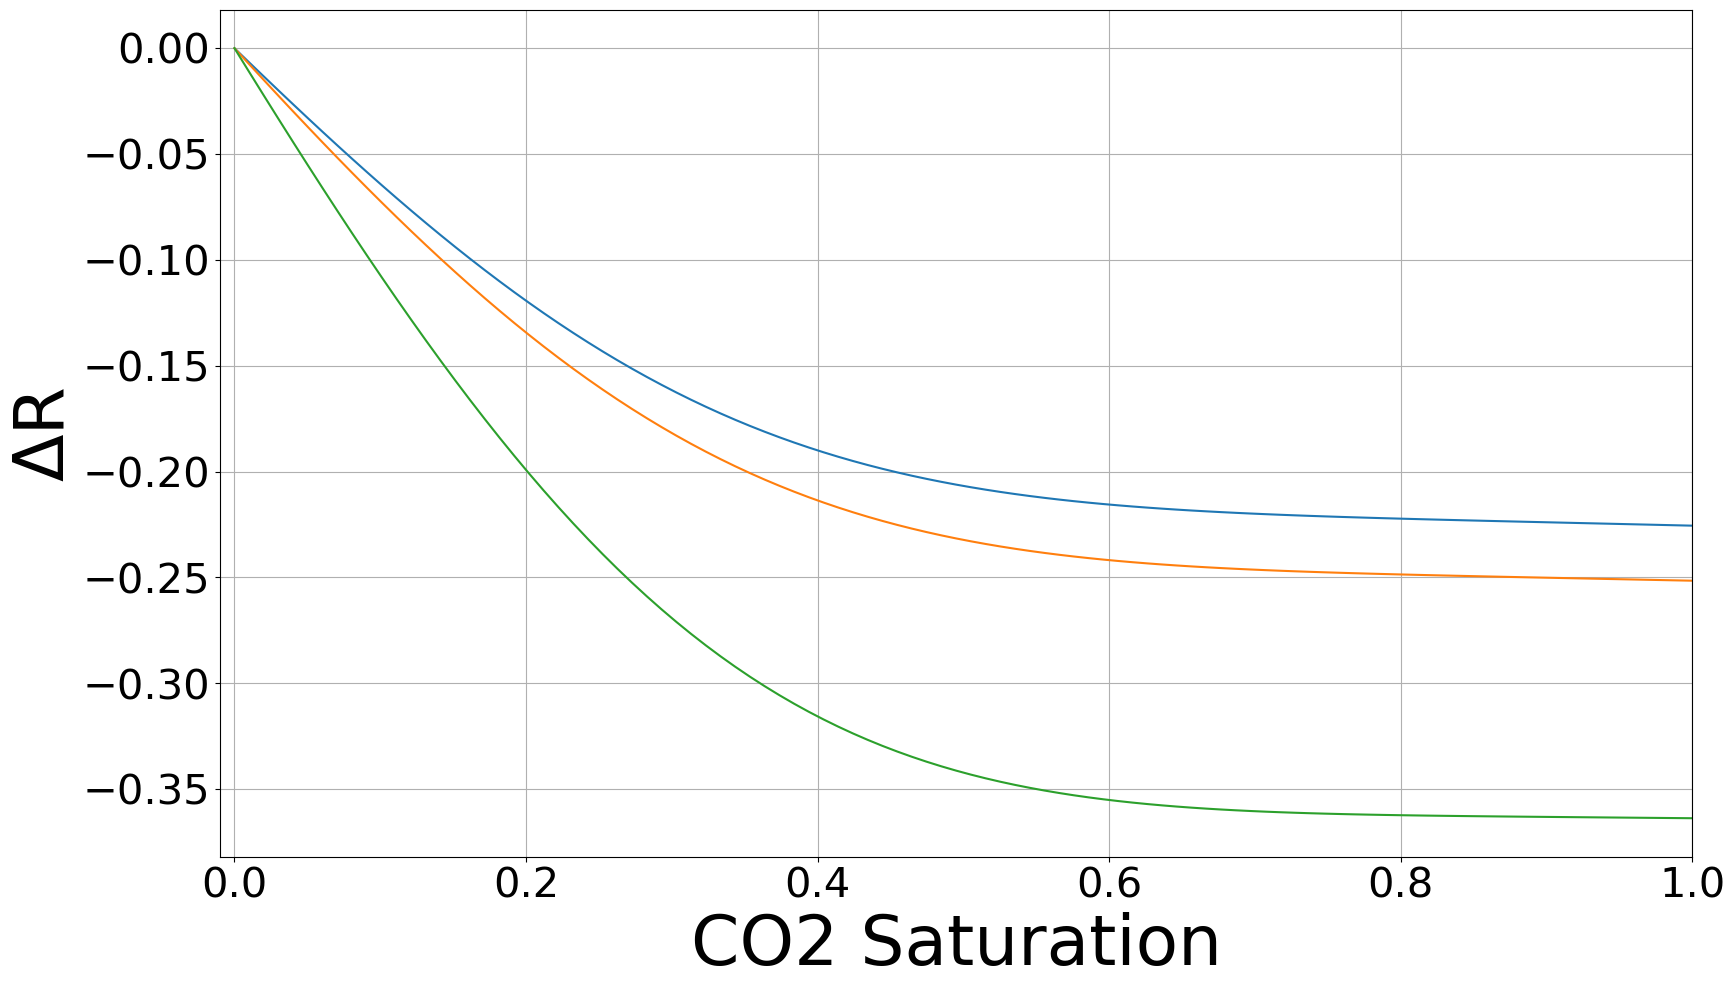

In [10]:
class SleipnerModel(EM, Fluid, BW, utils, GM):
    def __init__(self):
        super().__init__() #Initialize rockphypy
        #Data from Furre, Kiær, et al. (2015).
        self.cores = [
            {"velocity": 2025, "porosity": 0.37, "water_saturation": 1}
        ] 
        #---------Table  5.1.1----------#
        self.G = 0.951
        self.P0, self.T0 = 8.65, 37
        self.sigma = 7.7
        self.K0, self.G0 = 39.29, 44
        self.porosity = 0.36
        self.phic = 0.4
        self.rho_grain = 2.67
        self.rho_c, self.K_c, self.G_c = 2.65, 37, 44
        self.rho_brine, self.K_brine = 1.03, 2.3
        self.rho_co2, self.K_co2 = 0.7, 0.075
        self.G_brine, self.G_co2 = 1/1e40, 1/1e40
        self.salinity = 140000
        #--------------------------------#
        
        self.f = 0.1 #reduced shear factor
        self.scheme = 1 #cementation scheme
        self.phic_ = np.linspace(1e-9, self.phic, 100)
        self.phib_p = [0.35] #well-sorted end member
        self.C = 20-34*self.porosity + 14*self.porosity**2 #Equation 3.11
        self.Sw_values = np.linspace(1, 0, 100)
        self.phi_values = np.linspace(1e-9, 1, 100)
        
    def calculate_vp_vs(self, K_sat, G_sat, rho): #Calculate seismic velocities
        Vp = np.sqrt((K_sat + (4 / 3) * G_sat) / rho) #Equation 3.1
        Vs = np.sqrt(G_sat / rho) #Equation 3.2
        return Vp, Vs 

    def plot_bounds_and_critical_porosity(self): #Calculate rock physics bounds for solid-brine constituents
        volumes = np.vstack((1 -  self.phi_values, self.phi_values)).T
        K = np.array([self.K0, self.K_brine])
        G = np.array([self.G0, self.G_brine])
        K_v, K_r, K_h = self.VRH(volumes, K)
        G_v, G_r, G_h = self.VRH(volumes, G)
        K_UHS, G_UHS = self.HS(1 -  self.phi_values, self.K0, self.K_brine, self.G0, self.G_brine, bound='upper')
        K_LHS, G_LHS = self.HS(1 -  self.phi_values, self.K0, self.K_brine, self.G0, self.G_brine, bound='lower')
        
        rho_bulk = (self.rho_grain * (1 - self.phi_values) + self.rho_brine * self.phi_values)*1e3 #Equation 3.8
        
        plt.figure(figsize=(15, 11))
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlabel('Porosity', fontsize=50)
        plt.xlim(-0.01,1)
        plt.ylabel('P-wave Velocity [m/s]', fontsize=50)
        plt.plot(self.phi_values, self.calculate_vp_vs(K_v*1e9, G_v*1e9,rho_bulk)[0], label='Voigt',linestyle='-',color='blue')
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_r*1e9, G_r*1e9,rho_bulk)[0], label='Reuss',linestyle='--',color='red',linewidth=3)
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_h*1e9, G_h*1e9, rho_bulk)[0], label='Voigt-Reuss-Hill',linestyle='-.',color='green')
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_UHS*1e9, G_UHS*1e9, rho_bulk)[0], label='Hashin-Shtrikman Upper',linestyle=':',color='purple')
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_LHS*1e9, G_LHS*1e9, rho_bulk)[0], label='Hashin-Shtrikman Lower',linestyle='-',color='black')
        plt.plot(self.phi_values,  (self.calculate_vp_vs(K_UHS*1e9, G_UHS*1e9, rho_bulk)[0]+ self.calculate_vp_vs(K_LHS*1e9, G_LHS*1e9,rho_bulk)[0])/2, label='Hashin-Shtrikman Average',linestyle='-',color='orange')
        x,y = [], []
        for core in self.cores:
            x.append(core['porosity'])
            y.append(core['velocity'])
        plt.scatter(x, y, marker="o", s=100, color='black', label=f"Core data from Sleipner")
        plt.grid(True)
        plt.savefig("Bounds_Sleipner.png")
        plt.show()

    def plot_sand_models(self): #Calculate brine-saturated P-wave velocities for the sandstone models
        plt.figure(figsize=(15,11))
        K_fri, G_fri = GM.softsand(self.K0, self.G0, self.phic_, self.phic, self.C, self.sigma, self.f)
        K_contcem, G_contcem = GM.contactcement(self.K0, self.G0, self.K_c, self.G_c,self.phic_, self.phic, self.C, self.scheme)
        K_contcem[self.phic_ < self.phib_p[0]], G_contcem[self.phi_values < self.phib_p[0]] = np.nan, np.nan
        for element in self.phib_p:
            K_constcem, G_constcem = GM.constantcement(element, self.K0, self.G0, self.K_c, self.G_c, self.phic_, self.phic, self.C, self.scheme)
            K_constcem[self.phic_ > element] = np.nan
            Vp_constcem, Vs_constcem, _ = Fluid.vels(K_constcem, G_constcem, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.phic_)
            plt.plot(self.phic_, Vp_constcem, label=f"Constant Cement Model, High-porosity end-member: {element}, Avseth (2000)", color="green", linestyle="-") 
        Vp_fri, Vs_fri, _ = Fluid.vels(K_fri, G_fri, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.phic_)
        Vp_contcem, Vs_contcem, _ = Fluid.vels(K_contcem, G_contcem, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.phic_)
        
        plt.plot(self.phic_, Vp_fri, label=f"Softsand (Friable Sand) Model, Avseth et al. (2010)", color="blue")
        plt.plot(self.phic_, Vp_contcem, label=f"Contact Cement Model, Dvorkin & Nur (1996)", color="red")
        x,y = [], []
        for core in self.cores:
            x.append(core['porosity'])
            y.append(core['velocity'])
        plt.scatter(x, y, marker="o", s=100, color='black', label=f"Values from Sleipner")
        plt.xlabel("Porosity", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlim(-0.01, 0.50)
        plt.ylabel("P-wave Velocity [m/s]", fontsize=50)
        plt.grid(True)
        plt.savefig(f"Cementation_Models_Sleipner.png")
        plt.show()

    def GassmannSubst(self, brie_exponents):
        plt.figure(figsize=(15, 10))

        #Appropriate rock physics model was friable-sand model
        K_dry, G_dry = GM.softsand(self.K0, self.G0, self.porosity, self.phic, self.C, self.sigma, self.f)
        
        #Gassmann substitution for different Brie exponents
        for brie in brie_exponents:
            K_fl_mix = Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, brie)
            rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values) #Equation 3.8 for phi=1
            Vp = []
            for i in range(len(self.Sw_values)):
                Vp.append(Fluid.vels(K_dry, G_dry, self.K0, self.rho_grain, K_fl_mix[i], rho_fl_mix[i], self.porosity)[0])
                
            plt.plot(1 - self.Sw_values, Vp, label=f"Brie: {brie}")
        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel('P-wave Velocity [m/s]', fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig("GassmannSubst_Sleipner.png")
        plt.show()
    
    def plot_reflectivity(self, brie, theta):
        plt.figure(figsize=(19,11))
        K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, brie)
        rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values) #Equation 3.8 for phi=1
        rho_bulk = self.rho_grain * (1 - self.porosity) + rho_fl_mix * self.porosity #Equation 3.8
        Vp_sh, rho_sh = 2150, 2.100 #From Table 5.3.1

        #Appropriate friable-sand model
        K_best_fit, G_best_fit = GM.softsand(self.K0, self.G0, self.porosity, self.phic, self.C, self.sigma, self.f)
        Vp_best_fit, R_array = [], []
        for i in range(len(self.Sw_values)):
            Vp_best_fit.append(Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix[i], rho_fl_mix[i], self.porosity)[0])
        a1, rho1 = Vp_sh, rho_sh

        #Calculate reflectivity change for different incidence angles from Equation 4.3
        for angle_deg in theta:
            R_array = []
            angle_rad = np.radians(angle_deg)
            for i in range(len(self.Sw_values)):
                a2, rho2 = Vp_best_fit[i], rho_bulk[i]
                a = (a1 + a2) / 2
                rho = (rho1 + rho2) / 2
                da = a2 - Vp_best_fit[0]
                drho = rho2 - rho_bulk[0]
                R = 0.5 * ((drho / rho) + (da / a)) + 0.5 * (da / a) * (np.tan(angle_rad) ** 2)
                R_array.append(R)
                
            plt.plot(1 - self.Sw_values, R_array, label=f"Reflectivity (Soft sand)")
        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel("ΔR", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlim(-0.01, 1)
        plt.grid(True)
        plt.savefig(f"R_Sleipner.png")
        plt.show()

    def plot_dt_reflected(self, Z, theta):
        plt.figure(figsize=(15, 11))
        dZ = 0 #assumed no thickness change

        #Calculate reflected time-shift from Equation 4.6 for different incidence angles using the Gassmann substituted velocities
        for angle in theta:
            angle = angle*(np.pi/180) #to radians
            dT = []
            s = Z/np.cos(angle)
            K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, 5)
            rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values)
            rho_bulk = self.rho_grain * (1 - self.porosity) + rho_fl_mix * self.porosity 
            K_best_fit, G_best_fit = GM.softsand(self.K0, self.G0, self.porosity, self.phic, self.C, self.sigma, self.f)
            Vp = Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix, rho_fl_mix, self.porosity)[0]
            for i in range(len(self.Sw_values)):
                T1 = 2 * s / Vp[0]
                dt = (dZ - (1 + np.tan(angle) ** 2) * ((Vp[i] - Vp[0]) / Vp[0])) * T1
                dT.append(dt * 1000)  # Convert to milliseconds
                
            plt.plot(1 - self.Sw_values, dT, label=f"Angle = {angle} degrees")
        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel("ΔT [ms]", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig(f"dT_Sleipner.png")
        plt.show()

    def plot_dt_diving(self, Z, x, saturations):
        v0, depth= 1657, 718 #defining surface velocity
        plt.figure(figsize=(15, 11))

        #Calculate diving wave time-shifts for different saturations
        for sat in saturations:
            K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, sat, 5)
            rho_fl_mix = self.rho_brine * sat + self.rho_co2 * (1 - sat)
            K_best_fit, G_best_fit = GM.softsand(self.K0, self.G0, self.porosity, self.phic, self.C, self.sigma, self.f)

            #V_co2
            V2 = Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix, rho_fl_mix, self.porosity)[0]

            #V_initial
            V_res =  Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.porosity)[0]
            
            g = (V_res-v0)/(depth) #Equation 4.9

            #Equation 4.8
            for thickness in Z:
                dz = thickness/2
                dT = [] 
                for offset in x:
                    denom1 = 4 * v0**2 + g**2 * offset**2
                    sqrt1_inner = 1 - (4 * V2**2) / denom1
                    sqrt1 = np.sqrt(np.maximum(0, sqrt1_inner))
                    term1 = 4 * dz * sqrt1 / V2
                    sqrt2_inner = (g * (-8 * v0 * depth + g * (offset**2 - 4 * depth**2))) / denom1
                    #Avoid complex numbers by clipping negative values in sqrt
                    sqrt2 = np.sqrt(np.maximum(0, sqrt2_inner))
                    term2 = 4 * dz * sqrt2 / (v0 + g * depth)
                    dt = (term1 - term2) * 1000  #Convert to ms
                    dT.append(dt)
                    
                plt.plot(x, dT, label=f"Z = {thickness} m")
                dt_first = dT[0]
                plt.axhline(y=dt_first, linestyle="--", color="black", linewidth=3, label=f"ΔT at x[0], Sw = {sat:.2f}, Z = {thickness} m")
        plt.xlabel("Offset [m]", fontsize=50)
        plt.ylabel("ΔT [ms]", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig(f"dT_diving_Sleipner.png")
        plt.show()

    def plot_dt_refraction(self, lengths): #Time-shift for refracted wave
        plt.figure(figsize=(15, 11))
        K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, 5)
        rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values)
        K_best_fit, G_best_fit = GM.softsand(self.K0, self.G0, self.porosity, self.phic, self.C, self.sigma, self.f)
        Vp = Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix, rho_fl_mix, self.porosity)[0]

        #dV_res
        dVp = Vp - Vp[0] 

        #Equation 4.7 for different plume extensions
        for L in lengths:
            dT = (-L*(dVp/Vp[0]**2))*1000 #from s to ms
            
            plt.plot(1-self.Sw_values, dT, label=f"L = {L} m")
        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel("∆T [ms]", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig(f"dT_refraction_Sleipner.png")
        plt.show()


sleipner = SleipnerModel()
#sleipner.plot_bounds_and_critical_porosity()
#sleipner.plot_sand_models()
#sleipner.GassmannSubst([1,3,5,40])
#sleipner.plot_dt_reflected(5, [0, 20, 40])
#sleipner.plot_dt_diving([5], np.linspace(4385,20000, 1000), [0.1, 0.2, 0.3,0.4,0.5])
sleipner.plot_reflectivity(5, [0,20,40])
#sleipner.plot_dt_refraction([100, 500, 1000, 5000])


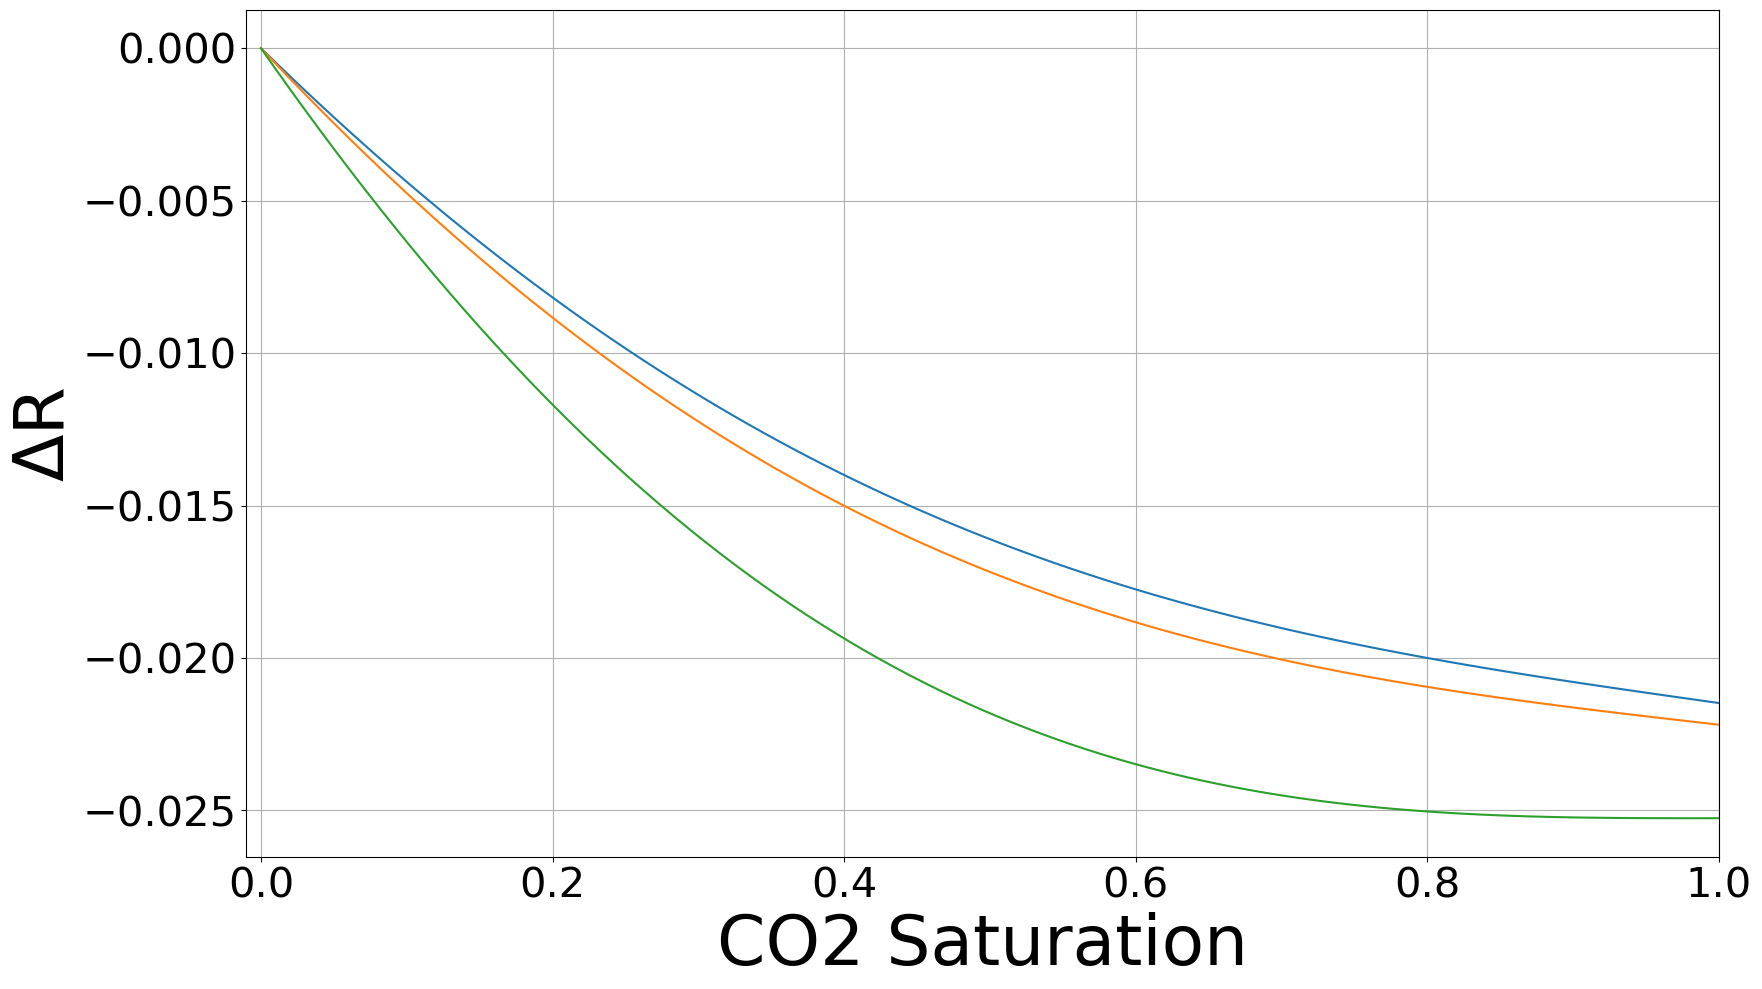

In [11]:
class SnohvitModel(EM, Fluid, BW, utils, GM):
    def __init__(self):
        super().__init__()  #Initialize rockphypy
        #Well log data from Grude (2014)
        self.cores = [
            {"velocity": 4200, "porosity": 0.2, "water_saturation": 1},
            {"velocity": 4150, "porosity": 0.19, "water_saturation": 1},
            {"velocity": 4250, "porosity": 0.18, "water_saturation": 1}
        ]
        #---------Table  5.1.1----------#
        self.G = 0.951
        self.P0, self.T0 = 29, 95
        self.sigma = 27
        self.K0, self.G0 = 37, 44
        self.porosity = 0.19
        self.phic = 0.4
        self.rho_grain = 2.65
        self.rho_c, self.K_c, self.G_c = 2.65, 37, 44
        self.rho_brine, self.K_brine = 1.07, 3.2
        self.rho_co2, self.K_co2 = 0.663, 1.791
        self.G_brine, self.G_co2 = 1/1e40, 1/1e40
        self.salinity = 140000
        #--------------------------------#
        
        self.f = 0.1 #reduced shear factor
        self.scheme = 1 #Cementation scheme
        self.phic_ = np.linspace(1e-9, self.phic, 100)
        self.phib_p = [0.35,0.3994] #well-sorted end members
        self.C = 20-34*self.porosity + 14*self.porosity**2 #Equation 3.11
        self.Sw_values = np.linspace(1, 0, 100)
        self.phi_values = np.linspace(1e-9, 1, 100)

    def calculate_vp_vs(self, K_sat, G_sat, rho):
        Vp = np.sqrt((K_sat + (4 / 3) * G_sat) / rho)
        Vs = np.sqrt(G_sat / rho)
        return Vp, Vs 

    def plot_bounds_and_critical_porosity(self):
        volumes = np.vstack((1 -  self.phi_values, self.phi_values)).T
        K = np.array([self.K0, self.K_brine])
        G = np.array([self.G0, self.G_brine])
        K_v, K_r, K_h = self.VRH(volumes, K)
        G_v, G_r, G_h = self.VRH(volumes, G)
        K_UHS, G_UHS = self.HS(1 -  self.phi_values, self.K0, self.K_brine, self.G0, self.G_brine, bound='upper')
        K_LHS, G_LHS = self.HS(1 -  self.phi_values, self.K0, self.K_brine, self.G0, self.G_brine, bound='lower')
        rho_bulk = (self.rho_grain * (1 - self.phi_values) + self.rho_brine * self.phi_values)*1e3
        plt.figure(figsize=(15, 11))
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlabel('Porosity', fontsize=50)
        plt.xlim(-0.01,1)
        plt.ylabel('P-wave Velocity [m/s]', fontsize=50)
        plt.plot(self.phi_values, self.calculate_vp_vs(K_v*1e9, G_v*1e9,rho_bulk)[0], label='Voigt',linestyle='-',color='blue')
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_r*1e9, G_r*1e9,rho_bulk)[0], label='Reuss',linestyle='--',color='red',linewidth=3)
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_h*1e9, G_h*1e9, rho_bulk)[0], label='Voigt-Reuss-Hill',linestyle='-.',color='green')
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_UHS*1e9, G_UHS*1e9, rho_bulk)[0], label='Hashin-Shtrikman Upper',linestyle=':',color='purple')
        plt.plot(self.phi_values,  self.calculate_vp_vs(K_LHS*1e9, G_LHS*1e9, rho_bulk)[0], label='Hashin-Shtrikman Lower',linestyle='-',color='black')
        plt.plot(self.phi_values,  (self.calculate_vp_vs(K_UHS*1e9, G_UHS*1e9, rho_bulk)[0]+ self.calculate_vp_vs(K_LHS*1e9, G_LHS*1e9,rho_bulk)[0])/2, label='Hashin-Shtrikman Average',linestyle='-',color='orange')
        x,y = [], []
        for core in self.cores:
            x.append(core['porosity'])
            y.append(core['velocity'])
        plt.scatter(x, y, marker="o", s=100, color='black', label=f"Core data from Snøhvit")
        plt.grid(True)
        plt.savefig("Bounds_Snohvit.png")
        plt.show()

    def plot_sand_models(self):
        plt.figure(figsize=(15,11))
        K_fri, G_fri = GM.softsand(self.K0, self.G0, self.phic_, self.phic, self.C, self.sigma, self.f)
        K_contcem, G_contcem = GM.contactcement(self.K0, self.G0, self.K_c, self.G_c,self.phic_, self.phic, self.C, self.scheme)
        K_contcem[self.phic_ < self.phib_p[0]], G_contcem[self.phi_values < self.phib_p[0]] = np.nan, np.nan
        for element in self.phib_p:
            K_constcem, G_constcem = GM.constantcement(element, self.K0, self.G0, self.K_c, self.G_c, self.phic_, self.phic, self.C, self.scheme)
            K_constcem[self.phic_ > element] = np.nan
            Vp_constcem, Vs_constcem, _ = Fluid.vels(K_constcem, G_constcem, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.phic_)
            plt.plot(self.phic_, Vp_constcem, label=f"Constant Cement Model, High-porosity end-member: {element}, Avseth (2000)", color="green", linestyle="-")
        Vp_fri, Vs_fri, _ = Fluid.vels(K_fri, G_fri, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.phic_)
        Vp_contcem, Vs_contcem, _ = Fluid.vels(K_contcem, G_contcem, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.phic_)
        plt.plot(self.phic_, Vp_fri, label=f"Softsand (Friable Sand) Model, Avseth et al. (2010)", color="blue")
        plt.plot(self.phic_, Vp_contcem, label=f"Contact Cement Model, Dvorkin & Nur (1996)", color="red")
        x,y = [], []
        for core in self.cores:
            x.append(core['porosity'])
            y.append(core['velocity'])
        plt.scatter(x, y, marker="o", s=100, color='black', label=f"Well data from Tubåen 1")
        plt.xlabel("Porosity", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlim(-0.01, 0.50)
        plt.ylabel("P-wave Velocity [m/s]", fontsize=50)
        plt.grid(True)
        plt.savefig(f"Cementation_Models_Snohvit.png")
        plt.show()

    def GassmannSubst(self, brie_exponents):
        end_memb = 0.3994
        plt.figure(figsize=(15, 10))
        K_dry, G_dry = GM.constantcement(end_memb, self.K0, self.G0, self.K_c, self.G_c, self.porosity, self.phic, self.C, self.scheme)
        
        for brie in brie_exponents:
            K_fl_mix = Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, brie)
            rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values) #Equation 3.8 for phi=1
            rho_bulk = self.rho_grain * (1 - self.porosity) + rho_fl_mix * self.porosity 
            Vp = []
            for i in range(len(self.Sw_values)):
                Vp.append(Fluid.vels(K_dry, G_dry, self.K0, self.rho_grain, K_fl_mix[i], rho_fl_mix[i], self.porosity)[0])
            plt.plot(1 - self.Sw_values, Vp, label=f"Brie: {brie}")

        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel('P-wave Velocity [m/s]', fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig("GassmannSubst_Snohvit.png")
        plt.show()
    
    def plot_reflectivity(self, brie, theta):
        end_memb = 0.3994
        plt.figure(figsize=(19,11))
        K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, brie)
        rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values)
        rho_bulk = self.rho_grain * (1 - self.porosity) + rho_fl_mix * self.porosity 
        Vp_sh, Vs_sh, rho_sh = 3250, 1350, (24.78*101.9716)/1e3 
        K_best_fit, G_best_fit = GM.constantcement(end_memb, self.K0, self.G0, self.K_c, self.G_c, self.porosity, self.phic, self.C, self.scheme)
        Vp_best_fit, R_array = [], []
        for i in range(len(self.Sw_values)):
            Vp_best_fit.append(Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix[i], rho_fl_mix[i], self.porosity)[0])
        a1, rho1 = Vp_sh, rho_sh
        for angle_deg in theta:
            R_array = []
            angle_rad = np.radians(angle_deg)
            for i in range(len(self.Sw_values)):
                a2, rho2 = Vp_best_fit[i], rho_bulk[i]
                a = (a1 + a2) / 2
                rho = (rho1 + rho2) / 2
                da = a2 - Vp_best_fit[0]
                drho = rho2 - rho_bulk[0]
                R = 0.5 * ((drho / rho) + (da / a)) + 0.5 * (da / a) * (np.tan(angle_rad) ** 2)
                R_array.append(R)
            plt.plot(1 - self.Sw_values, R_array, label=f"Reflectivity (Constant cement)")
        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel("ΔR", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlim(-0.01, 1)
        plt.grid(True)
        plt.savefig(f"R_Snohvit.png")
        plt.show()

    def plot_dt_reflected(self, Z, theta):
        end_memb = 0.3994
        plt.figure(figsize=(15, 11))
        dZ = 0 #no thickness change
        for angle in theta:
            angle = angle*(np.pi/180) #to radians
            dT = []
            s = Z/np.cos(angle)
            K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, 3)
            rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values)
            rho_bulk = self.rho_grain * (1 - self.porosity) + rho_fl_mix * self.porosity 
            K_best_fit, G_best_fit = GM.constantcement(end_memb, self.K0, self.G0, self.K_c, self.G_c, self.porosity, self.phic, self.C, self.scheme)
            Vp = Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix, rho_fl_mix, self.porosity)[0]
            for i in range(len(self.Sw_values)):
                T1 = 2 * s / Vp[0]
                dt = (dZ - (1 + np.tan(angle) ** 2) * ((Vp[i] - Vp[0]) / Vp[0])) * T1
                dT.append(dt * 1000)  #Convert to ms
            plt.plot(1 - self.Sw_values, dT, label=f"Angle = {angle} degrees")
        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel("ΔT [ms]", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig(f"dT_Snohvit.png")
        plt.show()

    def plot_dt_diving(self, Z, x, saturations):
        end_memb = 0.3994
        v0, depth= 1657, 2680
        plt.figure(figsize=(15, 11))
        for sat in saturations:
            K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, sat, 3)
            rho_fl_mix = self.rho_brine * sat + self.rho_co2 * (1 - sat)
            K_best_fit, G_best_fit = GM.constantcement(end_memb, self.K0, self.G0, self.K_c, self.G_c, self.porosity, self.phic, self.C, self.scheme)
            V2 = Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix, rho_fl_mix, self.porosity)[0]
            V_res =  Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, self.K_brine, self.rho_brine, self.porosity)[0]
            g = (V_res-v0)/(depth)
            for thickness in Z:
                dz = thickness/2
                dT = [] 
                for offset in x:
                    denom1 = 4 * v0**2 + g**2 * offset**2
                    sqrt1_inner = 1 - (4 * V2**2) / denom1
                    sqrt1 = np.sqrt(np.maximum(0, sqrt1_inner))
                    term1 = 4 * dz * sqrt1 / V2
                    sqrt2_inner = (g * (-8 * v0 * depth + g * (offset**2 - 4 * depth**2))) / denom1
                    #Avoid complex numbers by clipping negative values in sqrt
                    sqrt2 = np.sqrt(np.maximum(0, sqrt2_inner))
                    term2 = 4 * dz * sqrt2 / (v0 + g * depth)
                    dt = (term1 - term2) * 1000  #Convert to ms
                    dT.append(dt)
                plt.plot(x, dT, label=f"Z = {thickness} m")
                dt_first = dT[0]
                plt.axhline(y=dt_first, linestyle="--", color="black", linewidth=3, label=f"ΔT at x[0], Sw = {sat:.2f}, Z = {thickness} m")
        plt.xlabel("Offset [m]", fontsize=50)
        plt.ylabel("ΔT [ms]", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig(f"dT_diving_Snohvit.png")
        plt.show()

    def plot_dt_refraction(self, lengths):
        end_memb = 0.3994
        plt.figure(figsize=(15, 11))
        K_fl_mix =  Fluid.Brie(self.K_brine, self.K_co2, self.Sw_values, 3)
        rho_fl_mix = self.rho_brine * self.Sw_values + self.rho_co2 * (1 - self.Sw_values)
        K_best_fit, G_best_fit = GM.constantcement(end_memb, self.K0, self.G0, self.K_c, self.G_c, self.porosity, self.phic, self.C, self.scheme)
        Vp = Fluid.vels(K_best_fit, G_best_fit, self.K0, self.rho_grain, K_fl_mix, rho_fl_mix, self.porosity)[0]
        dVp = Vp - Vp[0] 
        for L in lengths:
            dT = (-L*(dVp/Vp[0]**2))*1000 #from s to ms
            plt.plot(1-self.Sw_values, dT, label=f"L = {L} m")
        plt.xlabel("CO2 Saturation", fontsize=50)
        plt.ylabel("∆T [ms]", fontsize=50)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.grid(True)
        plt.savefig(f"dT_refraction_Snohvit.png")
        plt.show()


snohvit = SnohvitModel()
#snohvit.plot_bounds_and_critical_porosity()
#snohvit.plot_sand_models()
#snohvit.GassmannSubst([1,3,5,40])
#snohvit.plot_dt_reflected(5, [0,20, 40])
snohvit.plot_reflectivity(3, [0,20,40])
#snohvit.plot_dt_refraction([100, 500, 1000, 5000])
#snohvit.plot_dt_diving([5], np.linspace(8125, 20000, 1000), [0.1, 0.2, 0.3,0.4,0.5])
